In [1]:
import numpy as np
from skfem import (
    MeshTri, Basis, FacetBasis, ElementTriP2, ElementTriP1, ElementVector,
    asm, bmat, condense, solve, BilinearForm, LinearForm, Mesh
)
from skfem.models.general import divergence
from skfem.models.poisson import vector_laplace
from skfem.helpers import grad, dot, laplacian
from skfem.helpers import laplacian, precompute_operators
import matplotlib.pyplot as plt

import scipy.sparse as sp
from scipy.sparse.linalg import eigsh, eigs, splu, LinearOperator

import scipy.linalg
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)



In [2]:
def graficar_stokes(u_sol, p_sol, mesh, basis_p, basis_u):
    
    Nu = basis_u.N
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))

    # Separar componentes de velocidad
    # Para ElementVector, los DOFs están organizados por componente
    n_nodes = Nu // 2
    u_x = u_sol[0::2]  # componente x
    u_y = u_sol[1::2]  # componente y

    # Magnitud de velocidad
    u_magnitude = np.sqrt(u_x**2 + u_y**2)

    # Crear bases escalares para visualizar cada componente
    basis_scalar = Basis(mesh, ElementTriP2(), intorder=4)

    # Componente u de la velocidad
    basis_scalar.plot(u_x, ax=axes[0, 0], shading='gouraud', colorbar=True, cmap='viridis')
    axes[0, 0].set_title(r'Velocidad $u_x$ (horizontal)')
    axes[0, 0].set_aspect('equal')

    # Componente v de la velocidad
    basis_scalar.plot(u_y, ax=axes[0, 1], shading='gouraud', colorbar=True, cmap='viridis')
    axes[0, 1].set_title(r'Velocidad $u_y$ (vertical)')
    axes[0, 1].set_aspect('equal')

    # Magnitud de velocidad
    basis_scalar.plot(u_magnitude, ax=axes[1, 0], shading='gouraud', colorbar=True, cmap='viridis')
    axes[1, 0].set_title(r'Magnitud de velocidad $|\mathbf{u}|$')
    axes[1, 0].set_aspect('equal')

    # Presión
    basis_p.plot(p_sol, ax=axes[1, 1], shading='gouraud', colorbar=True, colormap='viridis', cmap='viridis')
    axes[1, 1].set_title(r'Presión $p$')
    axes[1, 1].set_aspect('equal')
    plt.tight_layout()
    plt.show()

    # Campo vectorial de velocidad (quiver)
    # Para P2, necesitamos solo los valores en los vértices (primeros n_nodes)
    n_vertices = mesh.p.shape[1]
    
    # Extraer solo los valores en los vértices
    u_x_vertices = u_x[:n_vertices]
    u_y_vertices = u_y[:n_vertices]
    u_mag_vertices = np.sqrt(u_x_vertices**2 + u_y_vertices**2)
    
    # Obtener coordenadas de los nodos
    coords = mesh.p
    x_coords = coords[0, :]
    y_coords = coords[1, :]
    
    
    # Create a new figure for the quiver plot
    fig_quiver, ax_quiver = plt.subplots(1, 1, figsize=(10, 8))
    
    # Quiver plot
    quiver = ax_quiver.quiver(x_coords, y_coords, 
                      u_x_vertices, u_y_vertices, u_mag_vertices,
                      cmap='jet', scale=20, alpha=1, width=0.005)
    
    # Plot domain boundaries
    nodes  = mesh.p
    facets = mesh.facets
    boundary_facets = mesh.boundary_facets()

    # Plot all boundary facets
    for i, e in enumerate(boundary_facets):
        facets_e = facets[:, e]
        nodosx = nodes[0, facets_e]
        nodosy = nodes[1, facets_e]
        ax_quiver.plot(nodosx, nodosy, 'k-', linewidth=1.5, alpha=0.8)
    
    
    ax_quiver.set_title(r'Campo de velocidad $\mathbf{u}$')
    ax_quiver.set_aspect('equal')
    ax_quiver.set_xlabel('x')
    ax_quiver.set_ylabel('y')
    
    # Add colorbar
    cbar = plt.colorbar(quiver, ax=ax_quiver)
    cbar.set_label('Magnitud de velocidad')

    plt.tight_layout()
    plt.show()

In [3]:
malla = Mesh.load("data/Ugeom.obj", force_meshio_type='triangle')

In [4]:
nodes  = malla.p
facets = malla.facets
boundary_facets = malla.boundary_facets()
boundary_nodes = malla.boundary_nodes()

In [5]:
pared   = []
salida  = []
entrada = []
for i,e in enumerate(boundary_facets):
    facets_e = facets[:, e]
    nodox = nodes[0, facets_e]
    nodoy = nodes[1, facets_e]
    m = np.array([np.mean(nodox), np.mean(nodoy)])

    if m[1] > -2.0:
        pared.append(e)
    if m[1] <= -2.0 and m[0] > 0.0:
        salida.append(e)
    if m[1] <= -2.0 and m[0] < 0.0:
        entrada.append(e)

pared = np.array(pared)
salida = np.array(salida)
entrada = np.array(entrada)
coordenadas = nodes[:, boundary_nodes]

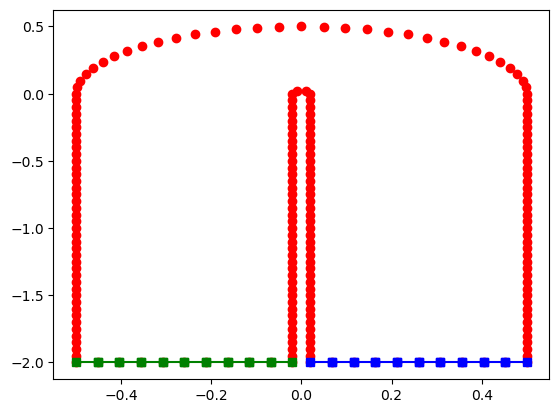

In [6]:
facets_e_list = []
for i, e in enumerate(boundary_facets):
    facets_e = facets[:, e]
    facets_e_list.append(facets_e)
    nodosx    = nodes[0, facets_e]
    nodosy    = nodes[1, facets_e]

    # plt.plot(nodosx, nodosy, 's-', color = 'b')
plt.plot(coordenadas[0, :], coordenadas[1, :], 'ro')

for i, e in enumerate(entrada):
    facets_e = facets[:, e]
    nodosx    = nodes[0, facets_e]
    nodosy    = nodes[1, facets_e]

    plt.plot(nodosx, nodosy, 's-', color = 'g')

for i, e in enumerate(salida):
    facets_e = facets[:, e]
    nodosx    = nodes[0, facets_e]
    nodosy    = nodes[1, facets_e]

    plt.plot(nodosx, nodosy, 's-', color = 'b')



## Navier Stokes

In [7]:
# Definir elementos y bases (P2 para velocidad, P1 para presión)
element = {
    'u': ElementVector(ElementTriP2()),
    'p': ElementTriP1(),
}
basis = {
    'u': Basis(malla, element['u'], intorder=4),
    'p': Basis(malla, element['p'], intorder=4),
}
basis_u, basis_p = basis['u'], basis['p']
Nu, Np = basis_u.N, basis_p.N
N      = Nu + Np

In [8]:
mu    = 0.035 # viscosidad dinámica
rho   = 1.0   # densidad
nu    = mu / rho # Viscosidad cinemática
V_car = 1.0    # Velocidad característica
L_car = 1.0    # Longitud característica
Re    = V_car * L_car / nu


In [9]:
@BilinearForm
def mass_matrix(u, v, w):
    return dot(u, v)
# Término convectivo linealizado
@BilinearForm
def convection(u, v, w):
    # w['w'] es la velocidad conocida (campo vectorial)
    advection_field = w['w']
    
    # grad(u) es el tensor gradiente de la velocidad trial
    grad_u = grad(u)
    
    # La operación es: w_j * (d u_i / d x_j) * v_i
    # j...  -> índice de w y de la derivada (contracción)
    # ij... -> índices del gradiente (componente i, derivada j)
    # i...  -> índice de v (componente i)
    return np.einsum('j...,ij...,i...->...', advection_field, grad_u, v)


# Ensamblaje de matrices
A =  asm(vector_laplace, basis_u)               
B = -asm(divergence, basis_u, basis_p)   

F_u = basis['u'].zeros()
F_p = basis['p'].zeros()
F = np.hstack([F_u, F_p])

In [10]:
def u_out_y(x, y):
    return  -(x-0.02)*(0.5-x) + y*0.0

dofs_entrada  = basis_u.get_dofs(entrada).all()
dofs_salida   = basis_u.get_dofs(salida).all()
dofs_p_salida = basis_p.get_dofs(salida).all()

xout   = basis_u.doflocs[0, dofs_salida[::2]] 
yout   = basis_u.doflocs[1, dofs_salida[1::2]]
xin   = basis_u.doflocs[0, dofs_entrada[::2]]
yin   = basis_u.doflocs[1, dofs_entrada[1::2]]

def u_in_y(x, y):
    return  (x-xin[1])*(xin[0]-x) + y*0.0

x_boundaries = np.zeros(Nu+Np)
x_boundaries[dofs_entrada[::2]]  = 0.0
x_boundaries[dofs_entrada[1::2]] = u_in_y(xin, yin)/np.max(u_in_y(xin, yin))

x_boundaries[Nu + dofs_p_salida[0]] = 0.0

D_all = np.concatenate([
    basis_u.get_dofs(pared).all(),
    basis_u.get_dofs(entrada).all(),
    Nu+np.array([dofs_p_salida[0]])
]) 

In [11]:
def solve_ns_picard(u_init, p_init, Re, max_iter, tol):
    u = u_init
    p = p_init
    for it in range(max_iter):
        # Campo de advección congelado w := u^(it) en puntos de cuadratura
        W = basis_u.interpolate(u)   

        # Ensambla bloque convectivo C(w)
        C = asm(convection, basis_u, w=W)

        # Matriz bloque del paso linealizado
        K = bmat([[(1/Re) * A + C, B.T ],
                  [B,              None]], format='csr')

        # Resolver
        sol = solve(*condense(K, F, D=D_all, x=x_boundaries))
        u_new = sol[:Nu]
        p_new = sol[Nu:Nu+Np]

        # Criterio de convergencia
        du = u_new - u
        rel_u = np.linalg.norm(du) / (np.linalg.norm(u_new) + 1e-16)

        dp = p_new - p
        rel_p = np.linalg.norm(dp) / (np.linalg.norm(p_new) + 1e-16)

        # # Sub-relajación si se desea
        u = u_new
        p = p_new

        if rel_u < tol and rel_p < tol:
            print(f"Convergió en {it+1} iteraciones, residuo {max(rel_u, rel_p):.4e}")
            return u, p, True
    print("No convergió en el número máximo de iteraciones")
    return u, p, False

### Ciclo Picard aumentando Re

In [12]:
# Calcular solución inicial de stokes
K_stokes = bmat([[mu * A,     B.T],  
                 [B,         None]], format='csr')

sol0 = solve(*condense(K_stokes, F, D=D_all, x=x_boundaries))
u_ref = sol0[:Nu].copy()
p_ref = sol0[Nu:Nu+Np].copy()

In [13]:
# Resolver incrementanto Re
Re = 100
Re_linspace = np.linspace(1, Re, 10)

for R in Re_linspace:
    print(f"Resolviendo para Re = {R:.2f}")
    u_ref, p_ref, flag = solve_ns_picard(u_ref, p_ref, R, max_iter=500, tol=1e-13)

    if not flag:
        print(f"No se pudo converger para este Re = {R:.2f}.")
        break

u_sol = u_ref
p_sol = p_ref


Resolviendo para Re = 1.00
Convergió en 6 iteraciones, residuo 9.3319e-14
Resolviendo para Re = 12.00
Convergió en 11 iteraciones, residuo 6.1388e-14
Resolviendo para Re = 23.00
Convergió en 14 iteraciones, residuo 2.1965e-14
Resolviendo para Re = 34.00
Convergió en 15 iteraciones, residuo 8.2692e-14
Resolviendo para Re = 45.00
Convergió en 17 iteraciones, residuo 2.0224e-14
Resolviendo para Re = 56.00
Convergió en 17 iteraciones, residuo 7.6365e-14
Resolviendo para Re = 67.00
Convergió en 18 iteraciones, residuo 6.5588e-14
Resolviendo para Re = 78.00
Convergió en 19 iteraciones, residuo 4.0276e-14
Resolviendo para Re = 89.00
Convergió en 20 iteraciones, residuo 3.4235e-14
Resolviendo para Re = 100.00
Convergió en 21 iteraciones, residuo 3.7175e-14


In [275]:
# # Campo de advección congelado w := u^(it) en puntos de cuadratura
# W = basis_u.interpolate(u_sol)   

# # Ensambla bloque convectivo C(w)
# C = asm(convection, basis_u, w=W)

# # Matriz bloque del paso linealizado
# K = bmat([[(1/Re) * A + C, B.T ],
#             [B,              None]], format='csr')

# K_wo_b, b, x, I = condense(K, F, D=D_all, x=x_boundaries)
# # Resolver
# sol = solve(K_wo_b, b)

# residual = K_wo_b @ sol - b
# max_val = np.max(np.abs(residual))
# max_pos = np.argmax(np.abs(residual))
# print(f"Máximo residuo: {max_val:.4e}")
# print(f"Posición del máximo: {max_pos}")
# print(f"DOF correspondiente: {I[max_pos]}")

In [276]:
u_scale = 3
p_scale = 1.05 * u_scale**2

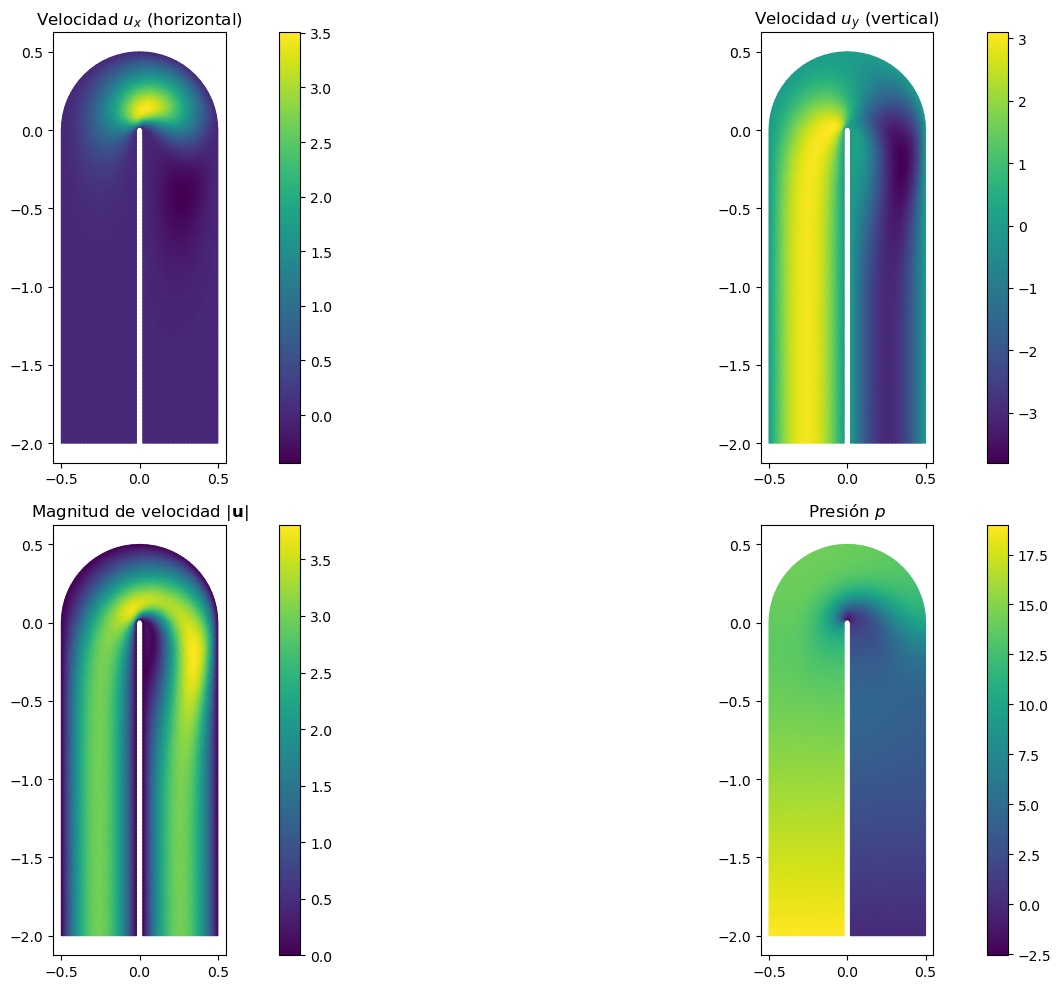

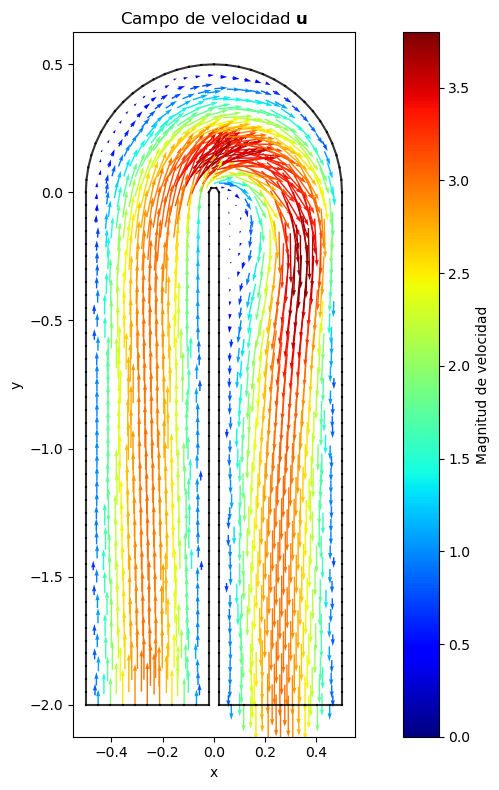

In [277]:
graficar_stokes(u_sol*u_scale, p_sol*p_scale, malla, basis_p, basis_u)

### Strong Loss

In [14]:
basis_x = basis_u.split_bases()[0]
basis_y = basis_u.split_bases()[1]
u_x = u_sol[0::2]
u_y = u_sol[1::2] 
p_sol = p_sol 

edofs_x, phix, grad_phix, laplacian_phix = precompute_operators(basis_x)
edofs_y, phiy, grad_phiy, laplacian_phiy = precompute_operators(basis_y)
edofs_p, phip, grad_phip, laplacian_phip = precompute_operators(basis_p)
# Velocidad y presión en puntos de cuadratura
u_val = np.einsum('dq, de -> qe', phix, u_x[edofs_x]) 
v_val = np.einsum('dq, de -> qe', phiy, u_y[edofs_y])
p_val = np.einsum('dq, de -> qe', phip, p_sol[edofs_p])

# Calcular operadores en coordenadas físicas
grad_u_fisico_x = np.einsum('de, diqe -> iqe', u_x[edofs_x], grad_phix)
grad_u_fisico_y = np.einsum('de, diqe -> iqe', u_y[edofs_y], grad_phiy)
grad_p_fisico   = np.einsum('de, diqe -> iqe', p_sol[edofs_p], grad_phip)
laplacian_u_x   = np.einsum('de, de -> e', u_x[edofs_x], laplacian_phix)
laplacian_u_y   = np.einsum('de, de -> e', u_y[edofs_y], laplacian_phiy)

du_dx = grad_u_fisico_x[0]
du_dy = grad_u_fisico_x[1]
dv_dx = grad_u_fisico_y[0]
dv_dy = grad_u_fisico_y[1]
dp_dx = grad_p_fisico[0]
dp_dy = grad_p_fisico[1]


# Residuo momentum en X: dp/dx - nu*Lap(u)

res_momentum_x = np.abs((u_val * du_dx + v_val * du_dy) + dp_dx - (laplacian_u_x/Re))

# Residuo momentum en Y: dp/dy - nu*Lap(v)
res_momentum_y = np.abs((u_val * dv_dx + v_val * dv_dy) + dp_dy - (laplacian_u_y/Re))

# Residuo Continuidad: du/dx + dv/dy
res_continuity = np.abs(du_dx + dv_dy)

print(f"Residuo momentum en X - min: {np.min(res_momentum_x):.4e}, max: {np.max(res_momentum_x):.4e}")
print(f"Residuo momentum en Y - min: {np.min(res_momentum_y):.4e}, max: {np.max(res_momentum_y):.4e}")
print(f"Residuo continuidad - min: {np.min(res_continuity):.4e}, max: {np.max(res_continuity):.4e}")

Residuo momentum en X - min: 3.6014e-09, max: 1.6434e+01
Residuo momentum en Y - min: 2.2975e-09, max: 2.0326e+01
Residuo continuidad - min: 5.5993e-10, max: 1.7802e+01


In [114]:
# Calcular el máximo error por elemento para cada tipo de residuo
max_res_momentum_x_per_elem = np.max(res_momentum_x, axis=0)
max_res_momentum_y_per_elem = np.max(res_momentum_y, axis=0)
max_res_continuity_per_elem = np.max(res_continuity, axis=0)

# Top 10 elementos con mayor error en momentum X
top_10_idx_momentum_x = np.argsort(max_res_momentum_x_per_elem)[-10:][::-1]
print("Top 10 elementos con mayor residuo en Momentum X:")
for i, idx in enumerate(top_10_idx_momentum_x):
    print(f"{i+1}. Elemento {idx}: {max_res_momentum_x_per_elem[idx]:.6e}")

print("\n" + "="*60 + "\n")

# Top 10 elementos con mayor error en momentum Y
top_10_idx_momentum_y = np.argsort(max_res_momentum_y_per_elem)[-10:][::-1]
print("Top 10 elementos con mayor residuo en Momentum Y:")
for i, idx in enumerate(top_10_idx_momentum_y):
    print(f"{i+1}. Elemento {idx}: {max_res_momentum_y_per_elem[idx]:.6e}")

print("\n" + "="*60 + "\n")

# Top 10 elementos con mayor error en continuidad
top_10_idx_continuity = np.argsort(max_res_continuity_per_elem)[-10:][::-1]
print("Top 10 elementos con mayor residuo en Continuidad:")
for i, idx in enumerate(top_10_idx_continuity):
    print(f"{i+1}. Elemento {idx}: {max_res_continuity_per_elem[idx]:.6e}")

Top 10 elementos con mayor residuo en Momentum X:
1. Elemento 1802: 1.668630e+01
2. Elemento 2337: 1.540812e+01
3. Elemento 2427: 1.108172e+01
4. Elemento 2437: 8.854847e+00
5. Elemento 2294: 7.939162e+00
6. Elemento 282: 6.976898e+00
7. Elemento 2304: 6.164541e+00
8. Elemento 1907: 5.195552e+00
9. Elemento 2464: 4.396982e+00
10. Elemento 2200: 4.039930e+00


Top 10 elementos con mayor residuo en Momentum Y:
1. Elemento 2437: 2.091637e+01
2. Elemento 1802: 2.022733e+01
3. Elemento 2337: 1.358869e+01
4. Elemento 282: 1.024242e+01
5. Elemento 1649: 7.388100e+00
6. Elemento 2304: 7.302722e+00
7. Elemento 1907: 6.714961e+00
8. Elemento 2453: 6.645701e+00
9. Elemento 2421: 6.454906e+00
10. Elemento 2427: 6.057776e+00


Top 10 elementos con mayor residuo en Continuidad:
1. Elemento 2337: 1.934904e+01
2. Elemento 2304: 1.922777e+01
3. Elemento 1649: 1.598344e+01
4. Elemento 1802: 1.238454e+01
5. Elemento 2437: 1.211168e+01
6. Elemento 67: 7.063625e+00
7. Elemento 1803: 5.496091e+00
8. Element

### Week loss using numpy

In [27]:
basis_x = basis_u.split_bases()[0]
basis_y = basis_u.split_bases()[1]
u_x = u_sol[0::2]
u_y = u_sol[1::2]

edofs_x, phix, grad_phix, laplacian_phix = precompute_operators(basis_x)
edofs_y, phiy, grad_phiy, laplacian_phiy = precompute_operators(basis_y)
edofs_p, phip, grad_phip, laplacian_phip = precompute_operators(basis_p)

In [28]:
# Velocidad y presión en puntos de cuadratura
u_val = np.einsum('dq, de -> qe', phix, u_x[edofs_x]) 
v_val = np.einsum('dq, de -> qe', phiy, u_y[edofs_y])
p_val = np.einsum('dq, de -> qe', phip, p_sol[edofs_p])

# Calcular operadores en coordenadas físicas
grad_u_fisico_x = np.einsum('de, diqe -> iqe', u_x[edofs_x], grad_phix)
grad_u_fisico_y = np.einsum('de, diqe -> iqe', u_y[edofs_y], grad_phiy)
grad_p_fisico   = np.einsum('de, diqe -> iqe', p_sol[edofs_p], grad_phip)
laplacian_u_x   = np.sum(u_x[edofs_x] * laplacian_phix, axis=0)
laplacian_u_y   = np.sum(u_y[edofs_y] * laplacian_phiy, axis=0)

du_dx = grad_u_fisico_x[0]
du_dy = grad_u_fisico_x[1]
dv_dx = grad_u_fisico_y[0]
dv_dy = grad_u_fisico_y[1]
dp_dx = grad_p_fisico[0]
dp_dy = grad_p_fisico[1]


DOF Global: [1802, 2337, 2427, 2437, 2294, 282, 2304]
Pertenece a los elementos (índices): [ 278  425 1564 1628 1635 1844]


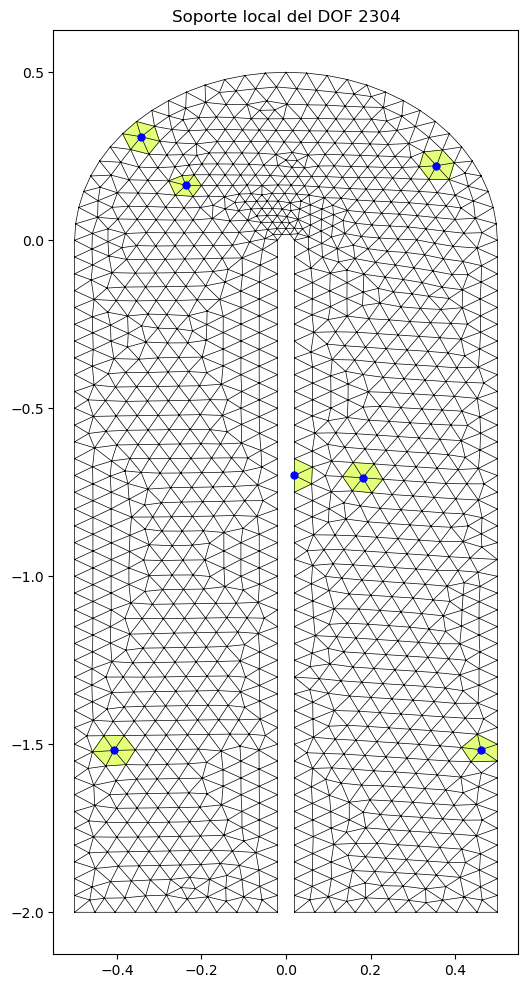

In [122]:
fig, ax = plt.subplots(figsize=(6, 12))
Mesh.draw(malla, ax=ax,)

index_dof = [1802, 2337, 2427, 2437, 2294, 282, 2304]  # Índice del DOF a analizar

for e in index_dof:
    element_indices = np.where(basis_u.element_dofs == e)[1]

    p = malla.p
    t_subset = malla.t.T[element_indices]
    plt.tripcolor(p[0], p[1], t_subset, 
                facecolors=np.ones(len(t_subset)), 
                cmap='Wistia', label='Elementos')

    # C. Graficar la ubicación exacta del DOF
    dof_loc = basis_u.doflocs[:, e]
    ax.plot(dof_loc[0], dof_loc[1], 'bo', markersize=5, label=f'DOF {e}')

plt.title(f"Soporte local del DOF {e}")
# plt.legend()
plt.show()

In [33]:
basis_x = basis_u.split_bases()[0]
basis_y = basis_u.split_bases()[1]
u_x = u_sol[0::2]
u_y = u_sol[1::2]

edofs_x, phix, grad_phix, _ = precompute_operators(basis_x, calculate_laplacian=False)
edofs_y, phiy, grad_phiy, _ = precompute_operators(basis_y, calculate_laplacian=False)
edofs_p, phip, _, _ = precompute_operators(basis_p, calculate_laplacian=False)
#(q,e) , (d,q), (d,i,q,e)

dx = basis_x.dx #(d,e)

# Transformar a Jax arrays
dtype_float = jnp.float64
dtype_int   = jnp.int64
u_sol = jnp.asarray(u_sol, dtype=dtype_float)
p_sol = jnp.asarray(p_sol, dtype=dtype_float)
dx    = jnp.asarray(dx, dtype=dtype_float)
edofs_x = jnp.asarray(edofs_x, dtype=dtype_int)
edofs_y = jnp.asarray(edofs_y, dtype=dtype_int)
edofs_p = jnp.asarray(edofs_p, dtype=dtype_int)
phix = jnp.asarray(phix, dtype=dtype_float)
phiy = jnp.asarray(phiy, dtype=dtype_float)
phip = jnp.asarray(phip, dtype=dtype_float)
grad_phix = jnp.asarray(grad_phix, dtype=dtype_float)
grad_phiy = jnp.asarray(grad_phiy, dtype=dtype_float)
basis_u_elements_dofs = jnp.asarray(basis_u.element_dofs, dtype=dtype_int)

In [34]:
def compute_residual_for_dof(target_dof, Re,
                             basis_u_element_dofs,
                             u_sol, p_sol,
                             edofs_x, edofs_y, edofs_p,
                             phix, phiy, phip,
                             grad_phix, grad_phiy,
                             dx):

    # 1) Identificar DOF en la base vectorial
    pos_local_u, elementos = jnp.where(basis_u_element_dofs == target_dof)
    elementos              = jnp.asarray(elementos)
    pos_local_u            = jnp.asarray(pos_local_u)

    # Componente (0: x, 1: y) y dof escalar local por elemento
    comp_local = pos_local_u % 2
    loc_scalar = pos_local_u // 2
    comp       = comp_local[0]

    # Todos los elementos del DOF
    Ne = len(elementos)

    # 2) Extraer pesos y edofs 
    weights_dx = dx[elementos, :].T   # (q, Ne)

    edofs_x_target = edofs_x[:, elementos]  # (d, Ne)
    edofs_y_target = edofs_y[:, elementos]  # (d, Ne)
    edofs_p_target = edofs_p[:, elementos]  # (d, Ne)

    u_x = u_sol[0::2]
    u_y = u_sol[1::2]

    u_x_target   = u_x[edofs_x_target]   # (d, Ne)
    u_y_target   = u_y[edofs_y_target]   # (d, Ne)
    p_sol_target = p_sol[edofs_p_target] # (d, Ne)

    # 3) Extraer gradiente de funciones test
    grad_phi_x_target = grad_phix[:, :, :, elementos] # (d, i, q, Ne)
    grad_phi_y_target = grad_phiy[:, :, :, elementos] # (d, i, q, Ne)

    # 4) Reconstruir u_h, p_h y gradientes
    # phix, phiy, phip tienen forma (d, q)
    u_x_h = jnp.einsum('de,dq->qe', u_x_target, phix)   # (q, Ne)
    u_y_h = jnp.einsum('de,dq->qe', u_y_target, phiy)   # (q, Ne)
    p_h   = jnp.einsum('de,dq->qe', p_sol_target, phip) # (q, Ne)

    grad_u_x_h = jnp.einsum('de,diqe->iqe', u_x_target, grad_phi_x_target) # (i, q, Ne)
    grad_u_y_h = jnp.einsum('de,diqe->iqe', u_y_target, grad_phi_y_target) # (i, q, Ne)
    # 5) Construir funcion test v y grad v sobre todos los elementos relacionados al DOF
    # grad_phi_x_e: (Ne, d, i, q)
    grad_phi_x_e = jnp.transpose(grad_phix[:, :, :, elementos], (3, 0, 1, 2))
    grad_phi_y_e = jnp.transpose(grad_phiy[:, :, :, elementos], (3, 0, 1, 2))
    idx_e = jnp.arange(Ne)          # (Ne,)

    if comp == 0:
        # DOF de ux: v = (phi, 0)
        # v_target_x: (q, Ne)
        v_target_x = phix[loc_scalar, :].T
        v_target_y = jnp.zeros_like(v_target_x)

        # grad_vx_target: (i, q, Ne)
        grad_vx_e = grad_phi_x_e[idx_e, loc_scalar, :, :]      # (Ne, i_dim, q)
        grad_vx_target = jnp.transpose(grad_vx_e, (1, 2, 0))    # (i_dim, q, Ne)
        grad_vy_target = jnp.zeros_like(grad_vx_target)

    else:
        # DOF de uy: v = (0, phi)
        v_target_y = phiy[loc_scalar, :].T
        v_target_x = jnp.zeros_like(v_target_y)

        grad_vy_e = grad_phi_y_e[idx_e, loc_scalar, :, :]      # (Ne, i_dim, q)
        grad_vy_target = jnp.transpose(grad_vy_e, (1, 2, 0))    # (i_dim, q, Ne)

        grad_vx_target = jnp.zeros_like(grad_vy_target)


    # 6) Calcular residuo
    diff_term_x = jnp.einsum('iqe,iqe->qe', grad_u_x_h, grad_vx_target)  # (q, Ne)
    diff_term_y = jnp.einsum('iqe,iqe->qe', grad_u_y_h, grad_vy_target)  # (q, Ne)

    conv_term_x = ((u_x_h * grad_u_x_h[0, :, :]) + (u_y_h * grad_u_x_h[1, :, :])) * v_target_x  # (q, Ne)
    conv_term_y = ((u_x_h * grad_u_y_h[0, :, :]) + (u_y_h * grad_u_y_h[1, :, :])) * v_target_y  # (q, Ne)

    # -p div v = -p (dvx/dx + dvy/dy)
    press_term_x = p_h * grad_vx_target[0, :, :]  # (q, Ne)
    press_term_y = p_h * grad_vy_target[1, :, :]  # (q, Ne)

    integrando_x = (1.0 / Re) * diff_term_x + conv_term_x - press_term_x  # (q, Ne)
    integrando_y = (1.0 / Re) * diff_term_y + conv_term_y - press_term_y  # (q, Ne)

    residuo_x = jnp.sum(integrando_x * weights_dx)  # escalar
    residuo_y = jnp.sum(integrando_y * weights_dx)

    return residuo_x, residuo_y


In [35]:
compute_residual_for_dof(1000, 100, basis_u_elements_dofs,
                         u_sol, p_sol, edofs_x, edofs_y, edofs_p,
                         phix, phiy, phip,
                         grad_phix, grad_phiy,
                         dx)

(Array(-3.76760255e-18, dtype=float64), Array(0., dtype=float64))

### Week loss using JAX

In [278]:
# Internal DOFs
dofs_boundary_u = jnp.asarray(basis_u.boundary().get_dofs().all())
dofs_all_u      = jnp.arange(basis_u.dofs.N, dtype=jnp.int64)
dofs_internal_u = jnp.setdiff1d(dofs_all_u, dofs_boundary_u)

dofs_boundary_p = jnp.asarray(basis_p.boundary().get_dofs().all())
dofs_all_p      = jnp.arange(basis_p.dofs.N, dtype=jnp.int64)
dofs_internal_p = jnp.setdiff1d(dofs_all_p, dofs_boundary_p)

basis_x = basis_u.split_bases()[0]
basis_y = basis_u.split_bases()[1]
u_x = u_sol[0::2]
u_y = u_sol[1::2]

edofs_x, phix, grad_phix, _ = precompute_operators(basis_x, calculate_laplacian=False)
edofs_y, phiy, grad_phiy, _ = precompute_operators(basis_y, calculate_laplacian=False)
edofs_p, phip, _, _ = precompute_operators(basis_p, calculate_laplacian=False)
#(q,e) , (d,q), (d,i,q,e)

dx = basis_x.dx #(d,e)

# Transformar a Jax arrays
dtype_float = jnp.float64
dtype_int   = jnp.int64
u_sol = jnp.asarray(u_sol, dtype=dtype_float)
p_sol = jnp.asarray(p_sol, dtype=dtype_float)
dx    = jnp.asarray(dx, dtype=dtype_float)
edofs_x = jnp.asarray(edofs_x, dtype=dtype_int)
edofs_y = jnp.asarray(edofs_y, dtype=dtype_int)
edofs_p = jnp.asarray(edofs_p, dtype=dtype_int)
phix = jnp.asarray(phix, dtype=dtype_float)
phiy = jnp.asarray(phiy, dtype=dtype_float)
phip = jnp.asarray(phip, dtype=dtype_float)
grad_phix = jnp.asarray(grad_phix, dtype=dtype_float)
grad_phiy = jnp.asarray(grad_phiy, dtype=dtype_float)
basis_u_elements_dofs = jnp.asarray(basis_u.element_dofs, dtype=dtype_int)

#### Error ecuaciones de momentum

In [279]:
def compute_residual_for_dof_padded(elem_idx, loc_scalar, comp, mask,
                                    Re,
                                    u_sol, p_sol,
                                    edofs_x, edofs_y, edofs_p,
                                    phix, phiy, phip,
                                    grad_phix, grad_phiy,
                                    dx):
    """
    elem_idx  : (Ne_max,)
    loc_scalar: (Ne_max,)
    comp      : escalar (0 o 1)
    mask      : (Ne_max,) con 1 para elementos reales, 0 padding
    """

    Ne_max = elem_idx.shape[0]

    # 2) Pesos y edofs para el DOF (Ne_max)
    weights_dx = dx[elem_idx, :].T                    # (q, Ne_max)
    weights_dx = weights_dx * mask[None, :]           # enmascara padding

    edofs_x_target = edofs_x[:, elem_idx]             # (d, Ne_max)
    edofs_y_target = edofs_y[:, elem_idx]             # (d, Ne_max)
    edofs_p_target = edofs_p[:, elem_idx]             # (d, Ne_max)

    u_x = u_sol[0::2]
    u_y = u_sol[1::2]

    u_x_target   = u_x[edofs_x_target]                # (d, Ne_max)
    u_y_target   = u_y[edofs_y_target]                # (d, Ne_max)
    p_sol_target = p_sol[edofs_p_target]              # (d, Ne_max)

    # 3) gradientes base sobre la estrella
    grad_phi_x_target = grad_phix[:, :, :, elem_idx]  # (d, i, q, Ne_max)
    grad_phi_y_target = grad_phiy[:, :, :, elem_idx]  # (d, i, q, Ne_max)

    # 4) Reconstruccion u_h, p_h, grad u_h
    u_x_h = jnp.einsum('de,dq->qe', u_x_target, phix)   # (q, Ne_max)
    u_y_h = jnp.einsum('de,dq->qe', u_y_target, phiy)   # (q, Ne_max)
    p_h   = jnp.einsum('de,dq->qe', p_sol_target, phip) # (q, Ne_max)

    grad_u_x_h = jnp.einsum('de,diqe->iqe', u_x_target, grad_phi_x_target) # (i, q, Ne_max)
    grad_u_y_h = jnp.einsum('de,diqe->iqe', u_y_target, grad_phi_y_target) # (i, q, Ne_max)

    # 5) Construir v y grad v para todos los elementos (sin if de Python)

    # grad_phi_x_e: (Ne_max, d, i, q)
    grad_phi_x_e = jnp.transpose(grad_phi_x_target, (3, 0, 1, 2))
    grad_phi_y_e = jnp.transpose(grad_phi_y_target, (3, 0, 1, 2))
    idx_e = jnp.arange(Ne_max)

    # v para ux
    v_x_candidate = phix[loc_scalar, :].T                       # (q, Ne_max)
    v_y_candidate = phiy[loc_scalar, :].T                       # (q, Ne_max)

    grad_vx_e_candidate = grad_phi_x_e[idx_e, loc_scalar, :, :] # (Ne_max, i_dim, q)
    grad_vy_e_candidate = grad_phi_y_e[idx_e, loc_scalar, :, :] # (Ne_max, i_dim, q)

    grad_vx_cand = jnp.transpose(grad_vx_e_candidate, (1, 2, 0)) # (i_dim, q, Ne_max)
    grad_vy_cand = jnp.transpose(grad_vy_e_candidate, (1, 2, 0)) # (i_dim, q, Ne_max)

    # comp==0 -> DOF de ux, comp==1 -> DOF de uy
    comp_is_x = (comp == 0)

    v_target_x = jnp.where(comp_is_x, v_x_candidate, jnp.zeros_like(v_x_candidate))
    v_target_y = jnp.where(comp_is_x, jnp.zeros_like(v_y_candidate), v_y_candidate)

    grad_vx_target = jnp.where(comp_is_x,
                               grad_vx_cand,
                               jnp.zeros_like(grad_vx_cand))
    grad_vy_target = jnp.where(comp_is_x,
                               jnp.zeros_like(grad_vy_cand),
                               grad_vy_cand)

    # 6) Residuo
    diff_term_x = jnp.einsum('iqe,iqe->qe', grad_u_x_h, grad_vx_target)
    diff_term_y = jnp.einsum('iqe,iqe->qe', grad_u_y_h, grad_vy_target)

    conv_term_x = ((u_x_h * grad_u_x_h[0, :, :]) +
                   (u_y_h * grad_u_x_h[1, :, :])) * v_target_x
    conv_term_y = ((u_x_h * grad_u_y_h[0, :, :]) +
                   (u_y_h * grad_u_y_h[1, :, :])) * v_target_y

    press_term_x = p_h * grad_vx_target[0, :, :]
    press_term_y = p_h * grad_vy_target[1, :, :]

    integrando_x = (1.0 / Re) * diff_term_x + conv_term_x - press_term_x
    integrando_y = (1.0 / Re) * diff_term_y + conv_term_y - press_term_y

    # enmascarar padding otra vez por seguridad
    integrando_x = integrando_x * mask[None, :]
    integrando_y = integrando_y * mask[None, :]

    residuo_x = jnp.sum(integrando_x * weights_dx)
    residuo_y = jnp.sum(integrando_y * weights_dx)

    return residuo_x, residuo_y


In [198]:
compute_residuals_vmap = jax.vmap(
    compute_residual_for_dof_padded,
    in_axes=(
        0,  # elem_idx   -> (n_dof_eval, Ne_max)
        0,  # loc_scalar -> (n_dof_eval, Ne_max)
        0,  # comp       -> (n_dof_eval,)
        0,  # mask       -> (n_dof_eval, Ne_max)
        None,  # Re
        None,  # u_sol
        None,  # p_sol
        None,  # edofs_x
        None,  # edofs_y
        None,  # edofs_p
        None,  # phix
        None,  # phiy
        None,  # phip
        None,  # grad_phix
        None,  # grad_phiy
        None   # dx
    )
)

compute_residual_jit = jax.jit(compute_residuals_vmap)

In [199]:
# def precompute_dof_connectivity(basis_u_element_dofs, dofs_eval):
#     """
#     basis_u_element_dofs: (n_elem, n_ldofs_vec)
#     dofs_eval: array de DOFs de velocidad a evaluar, shape (n_dof_eval,)
#     """

#     n_dof_eval = len(dofs_eval)

#     # 1) Calcular Ne_k para cada DOF
#     Ne_list = []
#     for dof in dofs_eval:
#         pos_local_u, elementos = jnp.where(basis_u_element_dofs == dof)
#         Ne_list.append(len(elementos))

#     Ne_max = max(Ne_list)

#     # 2) Inicializar arrays con padding
#     elem_idx_per_dof   = jnp.full((n_dof_eval, Ne_max), fill_value=-1, dtype=jnp.int64)
#     loc_scalar_per_dof = jnp.zeros((n_dof_eval, Ne_max), dtype=jnp.int64)
#     mask_per_dof       = jnp.zeros((n_dof_eval, Ne_max), dtype=jnp.float64)
#     comp_per_dof       = jnp.zeros((n_dof_eval,), dtype=jnp.int64)

#     # 3) Rellenar fila a fila
#     for r, dof in enumerate(dofs_eval):
#         pos_local_u, elementos = jnp.where(basis_u_element_dofs == dof)
#         comp_local = pos_local_u % 2  # sacar componente x o y
#         loc_scalar = pos_local_u // 2 # sacar índice de la base local

#         comp_per_dof       = comp_per_dof.at[r].set(comp_local[0])      # 0: ux, 1: uy
#         Ne                 = len(elementos)
#         elem_idx_per_dof   = elem_idx_per_dof.at[r, :Ne].set(elementos)
#         loc_scalar_per_dof = loc_scalar_per_dof.at[r, :Ne].set(loc_scalar)
#         mask_per_dof       = mask_per_dof.at[r, :Ne].set(1.0)     # el resto queda en 0
#     return elem_idx_per_dof, loc_scalar_per_dof, mask_per_dof, comp_per_dof


In [200]:
def precompute_dof_connectivity_V2(basis_u_element_dofs, dofs_eval):
    """
    basis_u_element_dofs: array (n_ldofs_vec, n_elem)

    dofs_eval: array 1D with the global DOFs to evaluate, shape (n_dof_eval,)

    Return:
        elem_idx_per_dof   : (n_dof_eval, Ne_max)   element indexes per DOF
        loc_scalar_per_dof : (n_dof_eval, Ne_max)   local scalar index (0..d-1)
        mask_per_dof       : (n_dof_eval, Ne_max)   1.0 if the entry is real, 0.0 if padding
        comp_per_dof       : (n_dof_eval,)          component (0: ux, 1: uy)
    """

    basis_u_element_dofs = np.asarray(basis_u_element_dofs, dtype=int)
    dofs_eval            = np.asarray(dofs_eval, dtype=int)

    n_ldofs_vec, n_elem = basis_u_element_dofs.shape  # (local_vec, elem)
    n_dof_eval          = dofs_eval.shape[0]

    # 1) Map  Global DOF -> row in output arrays
    max_dof    = int(basis_u_element_dofs.max())
    dof_to_row = -np.ones(max_dof + 1, dtype=int)
    for r, dof in enumerate(dofs_eval):
        if dof <= max_dof:
            dof_to_row[dof] = r

    # 2) For each DOF in dofs_eval, we will store a list of (elem, local_vec)
    elem_lists = [[] for _ in range(n_dof_eval)]

    # basis_u_element_dofs[local_vec, elem] = dof_global
    for local_vec in range(n_ldofs_vec):
        for elem in range(n_elem):
            dof = int(basis_u_element_dofs[local_vec, elem])
            r   = dof_to_row[dof]
            if r < 0:
                continue
            elem_lists[r].append((elem, local_vec))

    # 3) Compute Ne_max: maximum size of the DOF among the evaluated DOFs
    Ne_list = [len(lst) for lst in elem_lists]
    Ne_max  = max(Ne_list)

    # 4) Initialize output arrays (NumPy)
    elem_idx_per_dof   = np.full((n_dof_eval, Ne_max), fill_value=-1, dtype=int)
    loc_scalar_per_dof = np.zeros((n_dof_eval, Ne_max), dtype=int)
    mask_per_dof       = np.zeros((n_dof_eval, Ne_max), dtype=float)
    comp_per_dof       = np.zeros((n_dof_eval,), dtype=int)

    # 5) Fill  row by row:
    #    local_vec = pos_local_u
    #    comp_local = local_vec % 2
    #    loc_scalar = local_vec // 2
    for r in range(n_dof_eval):
        pares = elem_lists[r]
        if not pares:
            continue

        Ne = len(pares)
        elem_idx   = np.empty((Ne,), dtype=int)
        loc_scalar = np.empty((Ne,), dtype=int)
        comp_local = np.empty((Ne,), dtype=int)

        for k, (elem, local_vec) in enumerate(pares):
            elem_idx[k]   = elem
            comp_local[k] = local_vec % 2      # 0: component x, 1: component y
            loc_scalar[k] = local_vec // 2     # local scalar DOF
        elem_idx_per_dof[r, :Ne]   = elem_idx
        loc_scalar_per_dof[r, :Ne] = loc_scalar
        mask_per_dof[r, :Ne]       = 1.0
        comp_per_dof[r]            = comp_local[0]  # same component in the entire support

    # 6) Convert to JAX
    elem_idx_per_dof_j   = jnp.asarray(elem_idx_per_dof, dtype=jnp.int64)
    loc_scalar_per_dof_j = jnp.asarray(loc_scalar_per_dof, dtype=jnp.int64)
    mask_per_dof_j       = jnp.asarray(mask_per_dof, dtype=jnp.float64)
    comp_per_dof_j       = jnp.asarray(comp_per_dof, dtype=jnp.int64)

    return elem_idx_per_dof_j, loc_scalar_per_dof_j, mask_per_dof_j, comp_per_dof_j


In [251]:
# Precomputar conectividad de DOFs internos de velocidad
elem_idx, loc_scalar, mask, comp = \
    precompute_dof_connectivity_V2(basis_u_elements_dofs, dofs_internal_u)

In [284]:
res_x, res_y = compute_residual_jit(
    elem_idx,
    loc_scalar,
    comp,
    mask,
    Re,
    u_sol, p_sol,
    edofs_x, edofs_y, edofs_p,
    phix, phiy, phip,
    grad_phix, grad_phiy,
    dx
)
# res_x, res_y: shape (n_dof_eval,)
print("Residuos computados con JAX vmap:")
print(f'Componente x: Máximo error: {jnp.max(jnp.abs(res_x)):4e}, Minimo error: {jnp.min(jnp.abs(res_x)):4e}')
print(f'Componente y: Máximo error: {jnp.max(jnp.abs(res_y)):4e}, Minimo error: {jnp.min(jnp.abs(res_y)):4e}') # Por revisar

Residuos computados con JAX vmap:
Componente x: Máximo error: 2.175452e-16, Minimo error: 0.000000e+00
Componente y: Máximo error: 1.387779e-16, Minimo error: 0.000000e+00


In [235]:
a = np.array([[1],[2]])
a[:,0].shape

(2,)

In [223]:
res_continuity.shape

(1130,)

In [225]:
res_x.shape

(9464,)

#### Error ecuación de continuidad

In [293]:
def compute_residual_continuity(elem_idx, loc_scalar, mask,
                                u_sol,
                                edofs_x, edofs_y,
                                phix, phiy, phip,
                                grad_phix, grad_phiy,
                                dx):
    """
    elem_idx  : (Ne_max_p,) indices de elementos donde vive el DOF de presion
    loc_scalar: (Ne_max_p,) indice local escalar de la base de presion (P1) en cada elemento
    mask      : (Ne_max_p,) 1.0 si la entrada es real, 0.0 si es padding

    Campos:
      u_sol: vector de velocidad completo (tam 2*Nv)
      edofs_x, edofs_y: (d_u, n_elem) conectividad escalar P2 para ux, uy
      phix, phiy: (d_u, q) bases escalares P2 evaluadas en puntos de cuadratura
      phip: (d_p, q) bases escalares P1 evaluadas en puntos de cuadratura
      grad_phix, grad_phiy: (d_u, i, q, n_elem) gradiente de P2 en puntos de cuadratura
      dx: (n_elem, q) pesos de cuadratura (|J|*w)
    """

    # 1) Pesos de cuadratura para los elementos de la estrella del DOF de presion
    weights_dx = dx[elem_idx, :].T           # (q, Ne_max)
    weights_dx = weights_dx * mask[None, :]  # enmascarar padding

    # 2) Extraer DOFs de velocidad en esos elementos
    edofs_x_target = edofs_x[:, elem_idx]    # (d_u, Ne_max)
    edofs_y_target = edofs_y[:, elem_idx]    # (d_u, Ne_max)

    u_x = u_sol[0::2]
    u_y = u_sol[1::2]

    u_x_target = u_x[edofs_x_target]         # (d_u, Ne_max)
    u_y_target = u_y[edofs_y_target]         # (d_u, Ne_max)

    # 3) Gradientes de funciones base de velocidad en esos elementos
    grad_phi_x_target = grad_phix[:, :, :, elem_idx]  # (d_u, i, q, Ne_max)
    grad_phi_y_target = grad_phiy[:, :, :, elem_idx]  # (d_u, i, q, Ne_max)

    # 4) Reconstruir grad u en puntos de cuadratura
    grad_u_x_h = jnp.einsum('de,diqe->iqe', u_x_target, grad_phi_x_target)  # (i, q, Ne_max)
    grad_u_y_h = jnp.einsum('de,diqe->iqe', u_y_target, grad_phi_y_target)  # (i, q, Ne_max)

    # Divergencia: div u = dux/dx + duy/dy
    div_u_h = grad_u_x_h[0, :, :] + grad_u_y_h[1, :, :]  # (q, Ne_max)

    # 5) Construir funcion test q del espacio de presion (P1) en la estrella
    # phip: (d_p, q), loc_scalar: indice local P1 en cada elemento de la estrella
    q_candidate = phip[loc_scalar, :].T  # (q, Ne_max)

    # 6) Integrando: q * div u
    integrando = div_u_h * q_candidate    # (q, Ne_max)
    integrando = integrando * mask[None, :]  # anular padding por seguridad

    # 7) Integrar sobre elementos y cuadratura
    residuo = jnp.sum(integrando * weights_dx)  # escalar

    return residuo


In [294]:
compute_continuity_vmap = jax.vmap(
    compute_residual_continuity,
    in_axes=(
        0,  # elem_idx   -> (n_dof_eval, Ne_max)
        0,  # loc_scalar -> (n_dof_eval, Ne_max)
        0,  # mask       -> (n_dof_eval, Ne_max)
        None,  # u_sol
        None,  # edofs_x
        None,  # edofs_y
        None,  # phix
        None,  # phiy
        None,  # phip
        None,  # grad_phix
        None,  # grad_phiy
        None   # dx
    )
)

compute_continuity_jit = jax.jit(compute_continuity_vmap)

In [295]:
def precompute_dof_connectivity_pressure(basis_p_element_dofs, dofs_p_eval):
    """
    basis_p_element_dofs: (d_p, n_elem)
    dofs_p_eval: DOFs globales de presion (por ej. DOFs internos)
    """

    basis_p_element_dofs = np.asarray(basis_p_element_dofs, dtype=int)
    dofs_p_eval = np.asarray(dofs_p_eval, dtype=int)

    d_p, n_elem = basis_p_element_dofs.shape
    n_dof_eval = dofs_p_eval.shape[0]

    # mapa: dof_p_global -> fila
    max_dof_p = int(basis_p_element_dofs.max())
    dof_to_row = -np.ones(max_dof_p + 1, dtype=int)
    for r, dof in enumerate(dofs_p_eval):
        if dof <= max_dof_p:
            dof_to_row[dof] = r

    # listas por DOF
    elem_lists = [[] for _ in range(n_dof_eval)]

    # recorrer conectividad una vez
    for local_p in range(d_p):
        for elem in range(n_elem):
            dof = int(basis_p_element_dofs[local_p, elem])
            r = dof_to_row[dof]
            if r < 0:
                continue
            elem_lists[r].append((elem, local_p))

    # Ne_max
    Ne_list = [len(lst) for lst in elem_lists]
    if len(Ne_list) == 0 or max(Ne_list) == 0:
        raise ValueError("dofs_p_eval no tiene interseccion con basis_p_element_dofs")
    Ne_max = max(Ne_list)

    # inicializar arrays
    elem_idx_per_dof   = np.full((n_dof_eval, Ne_max), fill_value=-1, dtype=int)
    loc_scalar_per_dof = np.zeros((n_dof_eval, Ne_max), dtype=int)
    mask_per_dof       = np.zeros((n_dof_eval, Ne_max), dtype=float)

    # rellenar fila a fila
    for r in range(n_dof_eval):
        pares = elem_lists[r]
        if not pares:
            continue
        Ne = len(pares)

        elem_idx   = np.empty((Ne,), dtype=int)
        loc_scalar = np.empty((Ne,), dtype=int)

        for k, (elem, local_p) in enumerate(pares):
            elem_idx[k]   = elem
            loc_scalar[k] = local_p   # OJO: aqui NO hay //2

        elem_idx_per_dof[r, :Ne]   = elem_idx
        loc_scalar_per_dof[r, :Ne] = loc_scalar
        mask_per_dof[r, :Ne]       = 1.0

    # pasar a jax
    elem_idx_per_dof   = jnp.array(elem_idx_per_dof, dtype=jnp.int64)
    loc_scalar_per_dof = jnp.array(loc_scalar_per_dof, dtype=jnp.int64)
    mask_per_dof       = jnp.array(mask_per_dof, dtype=jnp.float64)

    return elem_idx_per_dof, loc_scalar_per_dof, mask_per_dof


In [296]:
elem_idx, loc_scalar, mask = \
    precompute_dof_connectivity_pressure(basis_p.element_dofs, dofs_internal_p)

In [297]:
res_continuity = compute_continuity_jit(
    elem_idx,
    loc_scalar,
    mask,
    u_sol,
    edofs_x, edofs_y,
    phix, phiy, phip,
    grad_phix, grad_phiy,
    jnp.asarray(basis_p.dx)
)
print(f"Residuos de continuidad: max {jnp.max(jnp.abs(res_continuity)):4e}, min {jnp.min(jnp.abs(res_continuity)):4e}")

Residuos de continuidad: max 1.383568e-16, min 5.293956e-23
